# Neural Network Model for Endangered Language Classification
**Description**: This notebook expands the baseline model by implementing a neural network classification on endangered languages.
We'll evaluate both the **granular level labels** and the **grouped level labels** to compare effectiveness.
- Granular labels (individual endangered categories)
- Grouped labels (combined into broader categories like "At Risk" or "Highly Endangered").

*Note*: According to the 'Final Project Guidelines', "If you implement a linear regression model, logistic
regression model, or any neural network, all code must be written in TensorFlow". Thus, this model uses TensorFlow. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2025-07-31 13:51:52.124681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 1: Load the final dataset, which is now a parquet file

In [2]:
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

### Step 2: Define Function to Combine Endangered Levels (for grouped classification)

In [3]:
# Create a grouped version of the endangered levels
def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_granular = df.copy()
df_grouped = df.copy()
df_grouped['level'] = df_grouped['level'].apply(combine_endangered_classes)

### Step 3: Define Function to Prepare features with Engineering

In [4]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national', 
                   'widely_spoken', 'country_count', 'max_urbanization', 
                   'max_internet_use']
    
    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
    
    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']
    
    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])
    
    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']
    
    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    
    return df_feat

### Step 4: Define Function to Handle Class Imbalance

In [5]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

### Step 5: Train Neural Network

In [6]:
def train_baseline_nn_tensorflow(df, label_name=""):
    """
    Train baseline neural network in TensorFlow/Keras with proper preprocessing
    and train/val/test split.
    """

    print("\nTraining Neural Network in TensorFlow...")

    # Prepare features with feature engineering function
    df_feat = prepare_features_with_engineering(df)

    # Select feature columns
    feature_cols = list(df.columns[4:12]) + ['language_tld', 'wikipedia_pages'] + [
        'digital_presence_ratio', 'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'log_wikipedia', 'log_tld_domains',
        'speakers_urbanization', 'speakers_internet'
    ]
    feature_cols = [col for col in feature_cols if col in df_feat.columns]

    X = df_feat[feature_cols].values.astype(np.float32)
    y = df_feat['level'].values

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split: 80% trainval, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )
    # Split trainval: 75% train, 25% val (train=60%, val=20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert labels to categorical for Keras
    num_classes = len(np.unique(y_encoded))
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Build a simple NN model
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    print(f"\nTraining Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Predictions for classification report/ confusion matrix
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_test_pred)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Neural Network {label_name} (Test Set)")
    plt.show()

    return model, scaler, le, feature_cols, history, (X_train, X_val, X_test), (y_train, y_val, y_test)


## Baseline Neural Network Model (no tuning)
Granular levels

- Training Accuracy: 74.9%
- Validation Accuracy: 71.4%
- Test Accuracy: 74.6%
- Notes: The model performs reasonably well overall, especially on classes like "Critically Endangered," "Endangered," "Extinct," and "Not Endangered," which have strong precision and recall. However, it struggles with "At risk" and "Severely Endangered," reflected in their lower recall and F1 scores. 

Grouped levels

- Training Accuracy: 86.6%
- Validation Accuracy: 88.5%
- Test Accuracy: 86.9%
- Notes: Grouping the labels leads to better performance. The model achieves high accuracy and F1 scores, especially on "At Risk," "Not Endangered," and "Extinct" classes. This suggests improved generalization and easier classification boundaries with grouped labels.

### Step 5.1: Train on Granular Labels

Training Neural Network on Granular Labels

Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 1s - 22ms/step - accuracy: 0.3211 - loss: 1.8582 - val_accuracy: 0.4251 - val_loss: 1.6268
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.4245 - loss: 1.5496 - val_accuracy: 0.4582 - val_loss: 1.3766
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.4681 - loss: 1.3573 - val_accuracy: 0.5331 - val_loss: 1.2281
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.5168 - loss: 1.2249 - val_accuracy: 0.5662 - val_loss: 1.1320
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.5401 - loss: 1.1476 - val_accuracy: 0.5993 - val_loss: 1.0743
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.5592 - loss: 1.1499 - val_accuracy: 0.6620 - val_loss: 1.0472
Epoch 7/100
54/54 - 0s - 2ms/step - accuracy: 0.5883 - loss: 1.1019 - val_accuracy: 0.6638 - val_loss: 1.0245
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.5894 - loss: 1.0843 - val_accuracy: 0.6829 - val_loss: 1.0018
Epoch 9/100
54/54 - 0s - 2ms/step 

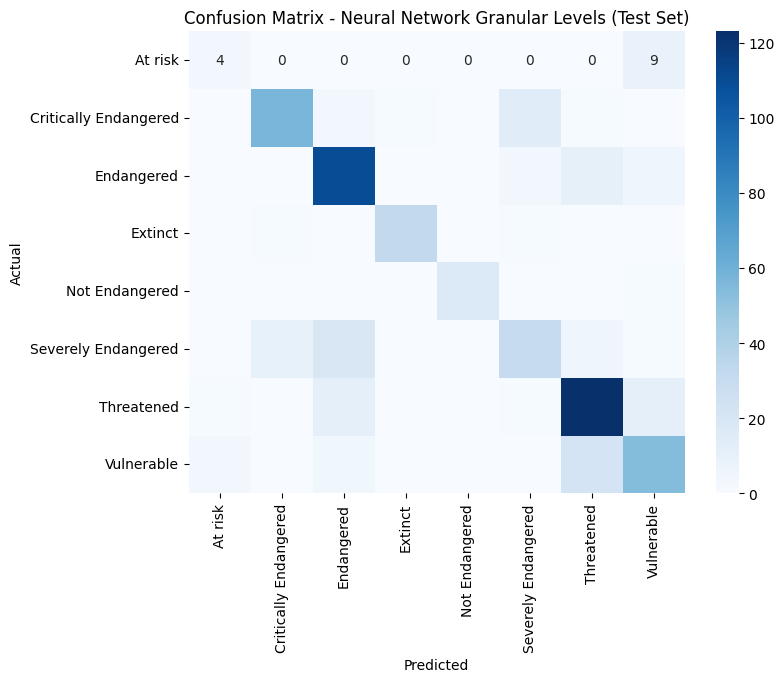

In [7]:
print("Training Neural Network on Granular Labels")
model, scaler, le, features, history, (X_train, X_val, X_test), (y_train, y_val, y_test) = train_baseline_nn_tensorflow(df_granular, label_name="Granular Levels")

### Step 5.2: Train on Grouped Labels


Training Neural Network on Grouped Labels

Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 1s - 24ms/step - accuracy: 0.5372 - loss: 1.2939 - val_accuracy: 0.6585 - val_loss: 0.9663
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.6585 - loss: 0.9374 - val_accuracy: 0.7038 - val_loss: 0.7715
Epoch 3/100
54/54 - 0s - 2ms/step - accuracy: 0.7027 - loss: 0.8472 - val_accuracy: 0.7422 - val_loss: 0.6695
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.7067 - loss: 0.7544 - val_accuracy: 0.7857 - val_loss: 0.6054
Epoch 5/100
54/54 - 0s - 2ms/step - accuracy: 0.7433 - loss: 0.7183 - val_accuracy: 0.7997 - val_loss: 0.5694
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.7410 - loss: 0.6862 - val_accuracy: 0.8171 - val_loss: 0.5391
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.7561 - loss: 0.6534 - val_accuracy: 0.8310 - val_loss: 0.5357
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.7567 - loss: 0.6453 - val_accuracy: 0.8467 - val_loss: 0.5135
Epoch 9/100
54/54 - 0s - 3ms/step 

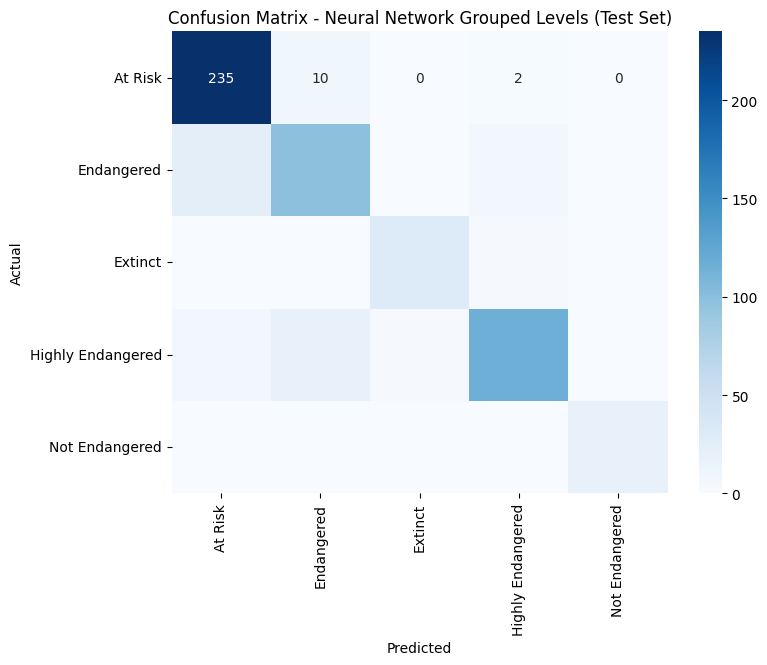

In [8]:
print("\nTraining Neural Network on Grouped Labels")
model, scaler, le, features, history, (X_train, X_val, X_test), (y_train, y_val, y_test) = train_baseline_nn_tensorflow(df_grouped, label_name="Grouped Levels")



### Step 6: Run Keras Tuner to find the best hyperparameters

In [9]:
num_classes = len(np.unique(y_train))

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    
    # Tune number of units in first dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout tuning
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)
    if hp_dropout > 0:
        model.add(keras.layers.Dropout(hp_dropout))
    
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    # tune the learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='endangered_language_tuning'
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

print("Best hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from tuner_dir/endangered_language_tuning/tuner0.json
Best hyperparameters:
{'units': 192, 'dropout': 0.4, 'learning_rate': 0.001}


## Tuned Neural Network Model
Granular levels

- Training Accuracy: 71.5%
- Validation Accuracy: 71.6%
- Test Accuracy: 71.1%
- Notes: Slight decrease in overall accuracy from baseline, but recall for rare classes improved significantly:
    - "At Risk" recall increased signficantly from 0.31 to 0.92
    - "Severely Endangered" recall increased moderately from 0.46 to 0.52

Grouped levels

- Training Accuracy: 84.5%
- Validation Accuracy: 86.9%
- Test Accuracy: 84.3%
- Notes: Slight drop in overall accuracy compared to baseline but improved recall for one class.
    - "Endangered" recall improved from 0.76 to 0.82
    - Other classes are mostly stable

### Step 7: Helper function to apply best parameters

In [19]:
def train_tuned_nn_tensorflow(df, best_hp, label_name=""):
    """
    Train neural network using best hyperparameters from tuning,
    keeping all baseline steps but adjusting model architecture and optimizer accordingly,
    and handling class imbalance via resampling.
    """

    print("\nTraining Tuned Neural Network in TensorFlow...")

    # Prepare features with feature engineering function
    df_feat = prepare_features_with_engineering(df)

    # Select feature columns
    feature_cols = list(df.columns[4:12]) + ['language_tld', 'wikipedia_pages'] + [
        'digital_presence_ratio', 'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'log_wikipedia', 'log_tld_domains',
        'speakers_urbanization', 'speakers_internet'
    ]
    feature_cols = [col for col in feature_cols if col in df_feat.columns]

    X = df_feat[feature_cols].values.astype(np.float32)
    y = df_feat['level'].values

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split into train/val/test sets same as baseline
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Handle class imbalance with SMOTE or fallback
    X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train, method='smote')

    # One-hot encode targets for categorical_crossentropy
    num_classes = len(np.unique(y_encoded))
    y_train_cat = tf.keras.utils.to_categorical(y_train_resampled, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Build model using best hyperparameters
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(best_hp.get('units'), activation='relu'),
        layers.Dropout(best_hp.get('dropout')),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model on resampled data
    history = model.fit(
        X_train_resampled, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train_resampled, y_train_cat, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    print(f"\nTraining Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Predictions for classification report/confusion matrix
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_test_pred)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Tuned Neural Network {label_name} (Test Set)")
    plt.show()

    return model, scaler, le, feature_cols, history, (X_train_resampled, X_val, X_test), (y_train_resampled, y_val, y_test)

### Granular Labels Tuned NN


Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 1s - 23ms/step - accuracy: 0.2985 - loss: 1.8938 - val_accuracy: 0.3902 - val_loss: 1.6699
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.4030 - loss: 1.5749 - val_accuracy: 0.4495 - val_loss: 1.4043
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.4634 - loss: 1.3970 - val_accuracy: 0.5139 - val_loss: 1.2403
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.5209 - loss: 1.2692 - val_accuracy: 0.5819 - val_loss: 1.1515
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.5499 - loss: 1.1898 - val_accuracy: 0.6010 - val_loss: 1.0967
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.5616 - loss: 1.1404 - val_accuracy: 0.6446 - val_loss: 1.0508
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.5662 - loss: 1.1156 - val_accuracy: 0.6289 - val_loss: 1.0304
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.5836 - loss: 1.0996 - val_accuracy: 0.6307 - val_loss: 1.0050
Epoch 9/100
54/54 - 0s - 3ms/step - accuracy: 0.5906 - loss: 1.0917 - val_acc

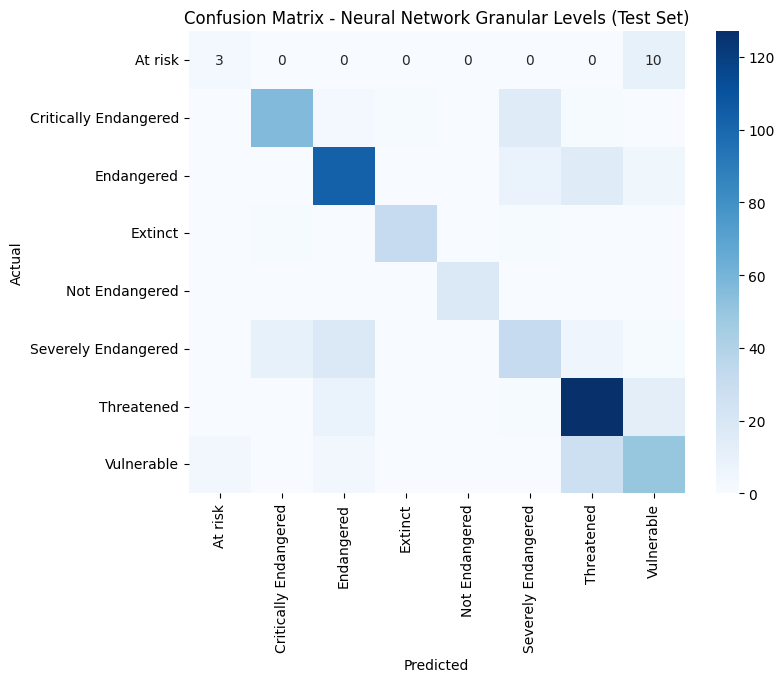

Epoch 1/100
27/27 - 1s - 50ms/step - accuracy: 0.1643 - loss: 1.9904 - val_accuracy: 0.2352 - val_loss: 1.8892 - learning_rate: 0.0010
Epoch 2/100
27/27 - 0s - 4ms/step - accuracy: 0.2422 - loss: 1.6381 - val_accuracy: 0.2422 - val_loss: 1.6529 - learning_rate: 0.0010
Epoch 3/100
27/27 - 0s - 4ms/step - accuracy: 0.3084 - loss: 1.4058 - val_accuracy: 0.4373 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 4/100
27/27 - 0s - 6ms/step - accuracy: 0.3728 - loss: 1.2899 - val_accuracy: 0.5383 - val_loss: 1.2806 - learning_rate: 0.0010
Epoch 5/100
27/27 - 0s - 4ms/step - accuracy: 0.4274 - loss: 1.1694 - val_accuracy: 0.5453 - val_loss: 1.2374 - learning_rate: 0.0010
Epoch 6/100
27/27 - 0s - 4ms/step - accuracy: 0.4686 - loss: 1.0984 - val_accuracy: 0.6272 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 7/100
27/27 - 0s - 4ms/step - accuracy: 0.4866 - loss: 1.0484 - val_accuracy: 0.6185 - val_loss: 1.0807 - learning_rate: 0.0010
Epoch 8/100
27/27 - 0s - 4ms/step - accuracy: 0.5331 - loss: 

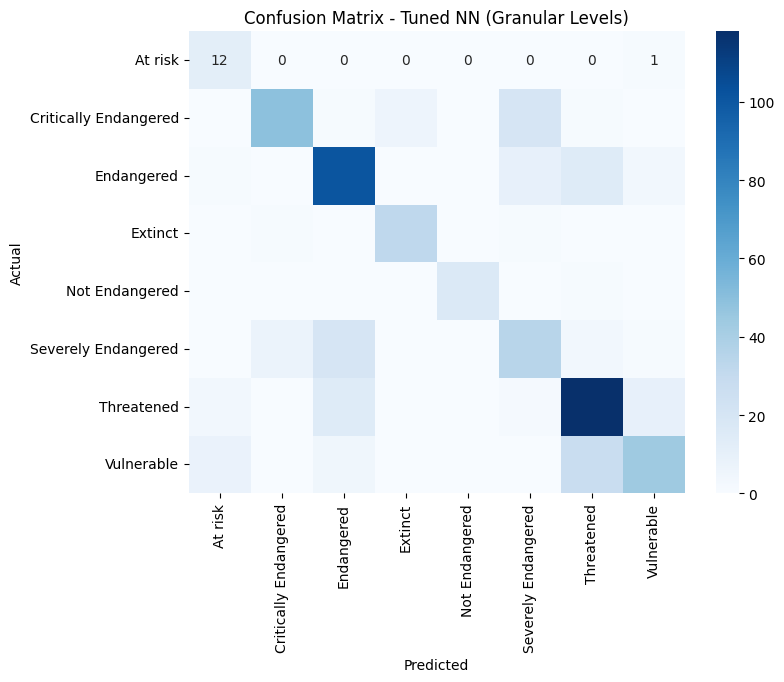

<Sequential name=sequential_10, built=True>

In [20]:
model, scaler, le, features, history, (X_train, X_val, X_test), (y_train, y_val, y_test) = train_baseline_nn_tensorflow(df_granular, label_name="Granular Levels")
best_hp = tuner.get_best_hyperparameters(1)[0]
num_classes = len(np.unique(y_train))

train_tuned_nn(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    best_hp, num_classes,
    label_encoder=le,
    label_name="Granular Levels"
)



Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 2s - 29ms/step - accuracy: 0.5267 - loss: 1.2823 - val_accuracy: 0.6516 - val_loss: 0.9653
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.6411 - loss: 0.9679 - val_accuracy: 0.7021 - val_loss: 0.7603
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.6765 - loss: 0.8400 - val_accuracy: 0.7439 - val_loss: 0.6612
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.7172 - loss: 0.7805 - val_accuracy: 0.7683 - val_loss: 0.6007
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.7224 - loss: 0.7084 - val_accuracy: 0.8101 - val_loss: 0.5626
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.7485 - loss: 0.6813 - val_accuracy: 0.8101 - val_loss: 0.5369
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.7538 - loss: 0.6809 - val_accuracy: 0.8484 - val_loss: 0.5257
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.7596 - loss: 0.6547 - val_accuracy: 0.8571 - val_loss: 0.5099
Epoch 9/100
54/54 - 0s - 3ms/step - accuracy: 0.7747 - loss: 0.6298 - val_acc

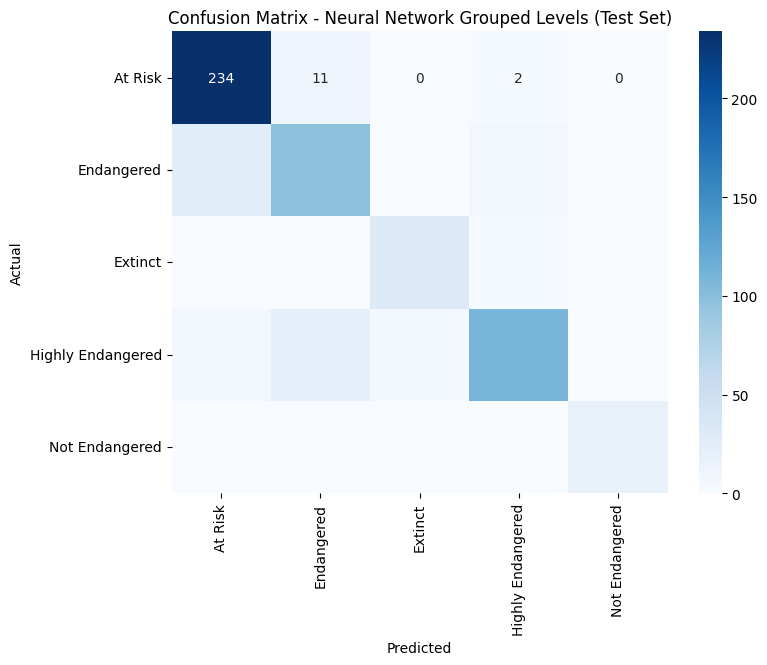

Epoch 1/100
27/27 - 1s - 50ms/step - accuracy: 0.2288 - loss: 1.4456 - val_accuracy: 0.2056 - val_loss: 1.4445 - learning_rate: 0.0010
Epoch 2/100
27/27 - 0s - 4ms/step - accuracy: 0.3159 - loss: 1.0608 - val_accuracy: 0.4251 - val_loss: 1.1429 - learning_rate: 0.0010
Epoch 3/100
27/27 - 0s - 4ms/step - accuracy: 0.5319 - loss: 0.8523 - val_accuracy: 0.6516 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 4/100
27/27 - 0s - 4ms/step - accuracy: 0.6458 - loss: 0.6999 - val_accuracy: 0.7195 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 5/100
27/27 - 0s - 4ms/step - accuracy: 0.6789 - loss: 0.6428 - val_accuracy: 0.7509 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 6/100
27/27 - 0s - 4ms/step - accuracy: 0.7015 - loss: 0.6612 - val_accuracy: 0.7178 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 7/100
27/27 - 0s - 4ms/step - accuracy: 0.7056 - loss: 0.5976 - val_accuracy: 0.7857 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 8/100
27/27 - 0s - 4ms/step - accuracy: 0.7247 - loss: 

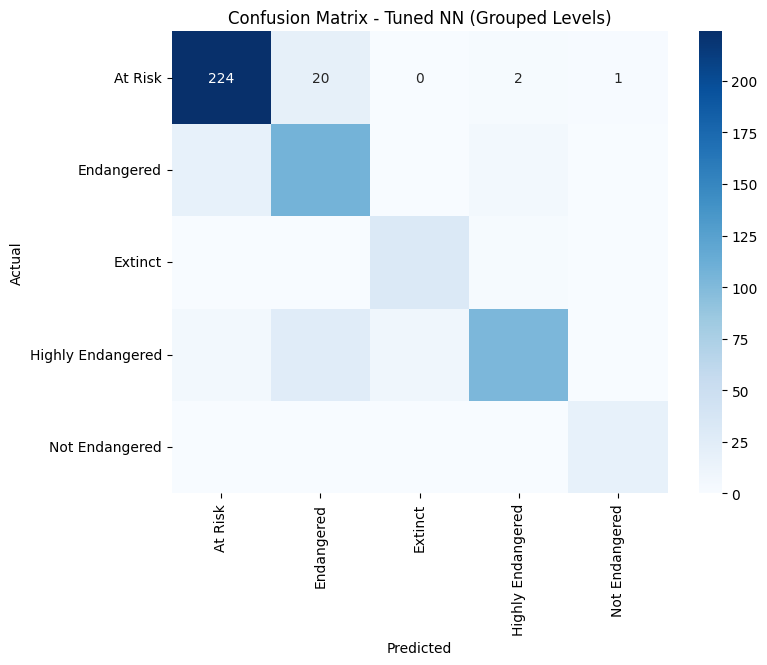

<Sequential name=sequential_12, built=True>

In [21]:
model, scaler, le, features, history, (X_train, X_val, X_test), (y_train, y_val, y_test) = train_baseline_nn_tensorflow(df_grouped, label_name="Grouped Levels")
num_classes = len(np.unique(y_train))

train_tuned_nn(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    best_hp, num_classes,
    label_encoder=le,
    label_name="Grouped Levels"
)


### Summary: 
The tuned model shows a slight decrease in overall accuracy compared to the baseline. However, it delivers substantial improvements in recall for rare and important classes, especially the “At risk” category in the granular levels, which rose dramatically from 0.31 to 0.92. The recall for “Severely Endangered” also improved moderately. For grouped levels, the recall for “Endangered” improved while “At Risk” recall remained high with only a minor decrease. These gains in class-wise sensitivity make the tuned model suitable for real-world tasks prioritizing detection of minority classes despite small overall accuracy drops.